# Stochastic Simulation Assignment 2

# Todo list:

#### 2)
use some z/t/etc test

#### 3)
priority queue impl does not yet exist

#### 4)
longtail dist should have same mean as other dists

In [1]:
import simpy
import queue
import numpy.random as rand
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from stochasticQueueing import *

## 2)

In [ ]:


def M_M_n_simulation(system_load, server_count, sim_duration, seed=42, queue_type='FIFO', warmup_duration=0):
    arrival_rate = server_count
    service_rate = 1 / system_load

    arrival_dist = lambda: rand.exponential(1 / arrival_rate)
    service_dist = lambda: rand.exponential(1 / service_rate)

    sim = ServerQueueingSimulation(
        arrival_dist, service_dist, server_count, queue_type=queue_type, sim_duration=sim_duration, seed=seed, warmup_duration=warmup_duration
    )
    return sim.results()



def B(c, rho):
    if(c==0):
        return 1
    Bprev = B(c-1, rho)

    return (rho * Bprev) / (c + rho*Bprev)

def PiW(c, rho):
    Bprev = B(c-1, c*rho)
    return (rho*Bprev) / (1-rho + rho*Bprev)

def expectedWaiting(c, rho):
    if c==1:
        return rho**2 / (1-rho)
    else:
        Pi = PiW(c, rho)
        return Pi / ((1-rho)*(c/rho))

server_counts = [1, 2, 4]
num_runs = 20
rand.seed(42)
# system_loads = 1 - np.logspace(-0.5, -4, 9)
system_loads = np.linspace(0.4,0.99, 10)
mean_wait_time = np.zeros_like(system_loads)
std_wait_time = np.zeros_like(system_loads)
for server_count in server_counts:
    for i, system_load in enumerate(system_loads):
        wait_times = np.zeros(num_runs)
        for j in range(num_runs):
            
            res = M_M_n_simulation(system_load, server_count, sim_duration=100000, warmup_duration=90000, seed=rand.randint(0,2**31-1))
            wait_times[j] = res['Average Wait Time']

        mean_wait_time[i] = np.mean(wait_times)
        std_wait_time[i] = np.std(wait_times)
    # plt.plot(1 - system_loads, mean_wait_time, label=f'{server_count}')
    print(server_count, np.mean(wait_times[-1]))
    plt.errorbar(system_loads, mean_wait_time, 1.96*std_wait_time/np.sqrt(num_runs), linestyle='', label=f'{server_count}', capsize=5, elinewidth=1)

plot_loads = np.linspace(system_loads[0], system_loads[-1], 1000)
for c in server_counts:
    plt.plot(plot_loads, expectedWaiting(c, plot_loads), linestyle=':', color='grey')
plt.grid()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rho$')
plt.ylabel('mean wait time')
plt.legend(title='server count')
plt.savefig('plots/2)')



1 36.658456685046325


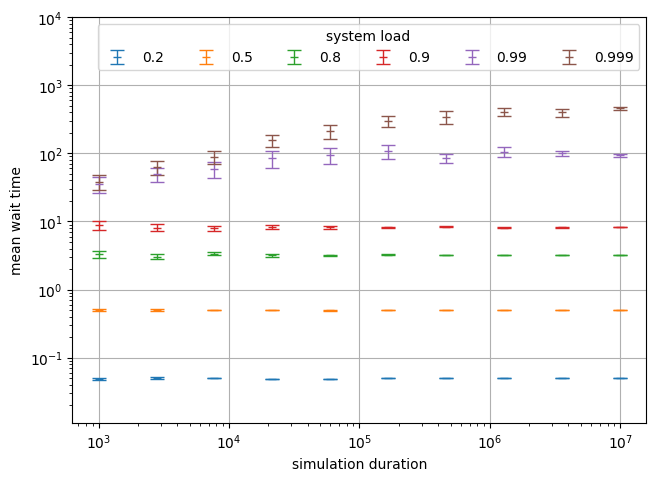

In [9]:
server_count = 1
run_count = [1000, 1000,200, 200,50, 50,20, 20, 10,5]
# run_count = [1,1,1,1,1]
rand.seed(42)
# system_loads = [0.9, 0.99, 0.999, 0.9999]
system_loads = [0.2,0.5,0.8,0.9,0.99, 0.999]
max_duration = np.logspace(3, 7, 10)
# mean_wait_time = np.zeros([len(system_loads), len(max_duration)])
# std_wait_time = np.zeros([len(system_loads), len(max_duration)])
# for l, system_load in enumerate(system_loads):
#     for i, duration in enumerate(max_duration):

#         num_runs = run_count[i]
        
#         wait_times = np.zeros(num_runs)
#         for j in range(num_runs):
            
#             res = M_M_n_simulation(system_load, server_count, duration, seed=rand.randint(0,2**31-1), warmup_duration=0.9*duration)
#             wait_times[j] = res['Average Wait Time']

#         mean_wait_time[l,i] = np.mean(wait_times)
#         std_wait_time[l,i] = np.std(wait_times)
#         print('.')
#     # plt.plot(1 - system_loads, mean_wait_time, label=f'{server_count}')
#     print(system_load, np.mean(std_wait_time[-1]))

# np.savez('data/duration-convergence-2.npz', mean_wait_time, std_wait_time)

arrays = np.load('data/duration-convergence-2.npz')
mean_wait_time, std_wait_time = arrays['arr_0'], arrays['arr_1']

for l, system_load in enumerate(system_loads):

    plt.errorbar(max_duration, mean_wait_time[l], 1.96*std_wait_time[l]/np.sqrt(run_count[l]), linestyle='', marker='_', label=f'{system_load}', capsize=5, elinewidth=1)

plt.tight_layout()
plt.grid()
plt.ylim(0.011,10000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'simulation duration')
plt.ylabel('mean wait time')
plt.legend(title='system load', loc=1, ncols=6)
plt.savefig('plots/duration-0.9-warmup.png', dpi=600 )


## 3)

todo: priotity queue

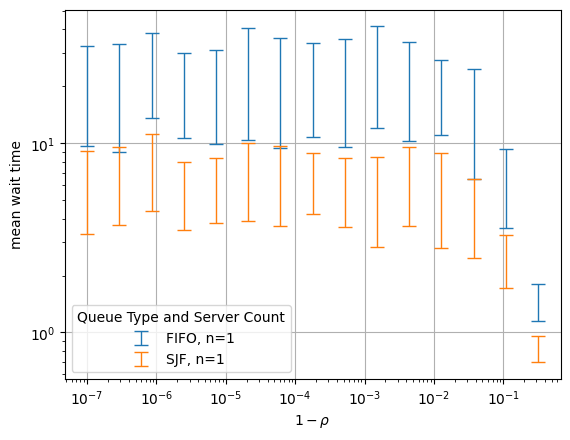

In [ ]:
server_counts = [1]
num_runs = 50
rand.seed(42)
system_loads = 1 - np.logspace(-0.5, -7, 15)

for queue_type in ['FIFO', 'SJF']:
    for server_count in server_counts:
        mean_wait_time = np.zeros_like(system_loads)
        std_wait_time = np.zeros_like(system_loads)
        for i, system_load in enumerate(system_loads):
            wait_times = np.zeros(num_runs)
            for j in range(num_runs):
                res = M_M_n_simulation(
                    system_load, server_count, 1000, seed=rand.randint(0, 2**31 - 1), queue_type=queue_type
                )
                wait_times[j] = res['Average Wait Time']

            mean_wait_time[i] = np.mean(wait_times)
            std_wait_time[i] = np.std(wait_times)
        plt.errorbar(
            1 - system_loads,
            mean_wait_time,
            std_wait_time,
            linestyle='',
            label=f'{queue_type}, n={server_count}',
            capsize=5,
            elinewidth=1,
        )

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$1-\rho$')
plt.ylabel('mean wait time')
plt.legend(title='Queue Type and Server Count')
plt.show()


## 4)
different service rates

In [ ]:

def M_X_n_simulation(system_load, server_count, sim_duration, seed=42, service_dist = None):

    arrival_rate = server_count
    job_completion_rate = 1/system_load
    
    arrival_dist = lambda : rand.exponential(1/arrival_rate)

    if service_dist == None:
        service_dist = lambda : rand.exponential(1/job_completion_rate)


    sim = ServerQueueingSimulation(arrival_dist, service_dist, server_count, sim_duration=sim_duration, seed=seed)

    return sim.results()



for service_type in ['exponential', 'deterministic (M/D/n)', 'hyperexponential']:

    service_rate = 1/0.9

    if service_type == 'exponential':
        service_dist =  lambda : rand.exponential(1 / service_rate)

    elif service_type == 'deterministic (M/D/n)':
        service_dist = lambda : 1/service_rate
        
    elif service_type == 'hyperexponential':
        def service_dist():
            if rand.rand() < 0.75:
                return rand.exponential(1.0)
            else:
                return rand.exponential(5.0)

    else:
        raise ValueError("Unsupported service time distribution")
    

    print(service_type, M_X_n_simulation(0.9, 1, 100000, service_dist=service_dist))

exponential {'Average Wait Time': 8.407823678698447, 'Rejection Rate': 0.0, 'Completed Jobs': 100008, 'Total Jobs': 100008, 'Rejected Jobs': 0}
deterministic (M/D/n) {'Average Wait Time': 4.0537288766632225, 'Rejection Rate': 0.0, 'Completed Jobs': 100391, 'Total Jobs': 100398, 'Rejected Jobs': 0}
hyperexponential {'Average Wait Time': 1948.6577772130813, 'Rejection Rate': 0.9747902469767992, 'Completed Jobs': 49774, 'Total Jobs': 50774, 'Rejected Jobs': 49494}
